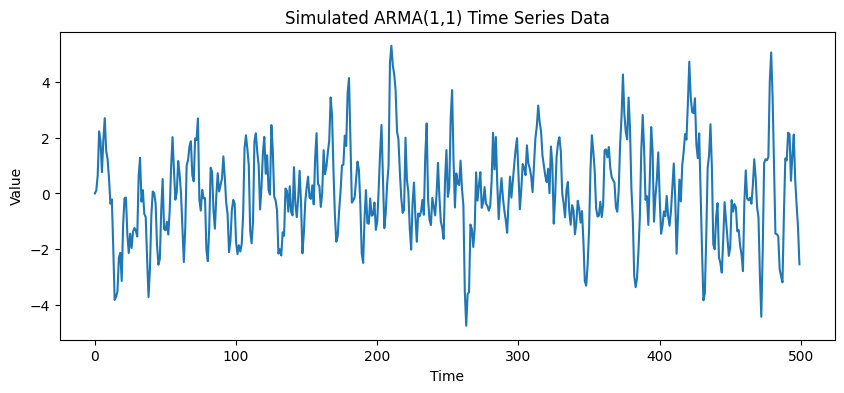

In [25]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.linalg import toeplitz  # Correct import for toeplitz function

# Step 1: Simulate data from an ARMA(1,1) process
# -----------------------------------------------

# Set seed for reproducibility
np.random.seed(42)

# Define ARMA(1,1) parameters (true parameters)
phi = 0.6    # AR coefficient
theta = 0.5  # MA coefficient

# Number of observations
n = 500

# Generate white noise (errors) with mean 0 and variance 1
e = np.random.normal(loc=0, scale=1, size=n)

# Initialize y array with zeros
y = np.zeros(n)

# Simulate ARMA(1,1) process using the recursive formula
# y_t = phi * y_{t-1} + e_t + theta * e_{t-1}
for t in range(1, n):
    y[t] = phi * y[t-1] + e[t] + theta * e[t-1]

# Plot the simulated time series data
plt.figure(figsize=(10, 4))
plt.plot(y)
plt.title('Simulated ARMA(1,1) Time Series Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()



In [26]:

# Step 2: Estimate AR parameters using Yule-Walker equations (First Step of Hannan-Rissanen Algorithm)
# ----------------------------------------------------------------------------------------------------

# The Yule-Walker equations are used to estimate the parameters of an AR(p) process.
# For an ARMA(p,q) process, we can approximate it with a high-order AR process.

# Choose a high order 'p' for the AR model approximation
p_order = 15  # Initial AR order for approximation

# Compute sample autocorrelation function up to lag 'p_order'
acf_vals = acf(y, nlags=p_order, fft=False)

# Set up the Yule-Walker equations using the autocorrelation function
# Build the Toeplitz matrix of autocorrelations
R = toeplitz(acf_vals[:p_order])

# Right-hand side vector of autocorrelations (lags 1 to p_order)
r = acf_vals[1:p_order+1]

# Solve the Yule-Walker equations to get AR coefficients
ar_coeffs = np.linalg.solve(R, r)

print("Estimated AR coefficients from Yule-Walker equations (First Step):")
for i, coeff in enumerate(ar_coeffs, 1):
    print(f"phi_{i}: {coeff:.4f}")



Estimated AR coefficients from Yule-Walker equations (First Step):
phi_1: 1.0824
phi_2: -0.5305
phi_3: 0.2765
phi_4: -0.2254
phi_5: 0.1934
phi_6: -0.0821
phi_7: -0.0001
phi_8: -0.0701
phi_9: 0.0684
phi_10: -0.0361
phi_11: 0.0762
phi_12: -0.0466
phi_13: -0.0080
phi_14: 0.0416
phi_15: -0.0199


In [27]:

# Step 3: Estimate MA parameters using residuals (Second Step of Hannan-Rissanen Algorithm)
# -----------------------------------------------------------------------------------------

# Compute the residuals from the AR(p_order) model
# Initialize residuals array
residuals = np.zeros(n)

# Compute residuals
for t in range(p_order, n):
    # Corrected slicing to get previous p_order observations
    y_lagged = y[t - p_order:t][::-1]
    y_pred = np.dot(ar_coeffs, y_lagged)
    residuals[t] = y[t] - y_pred

# Now, regress residuals on past residuals to estimate MA coefficients
# For an ARMA(1,1) model, we can set up the regression:
# residuals_t = theta * residuals_{t-1} + error_t

# Prepare data for regression
resid_t = residuals[p_order+1:]
resid_t1 = residuals[p_order:-1]

# Regress residuals on lagged residuals to estimate theta
X = resid_t1.reshape(-1, 1)

# Solve for theta using least squares
theta_est = np.linalg.lstsq(X, resid_t, rcond=None)[0][0]

print(f"\nEstimated MA coefficient from residuals regression (Second Step):")
print(f"theta: {theta_est:.4f}")




Estimated MA coefficient from residuals regression (Second Step):
theta: 0.0016


In [28]:

# Step 4: Refine AR and MA parameters (Third Step of Hannan-Rissanen Algorithm)
# -----------------------------------------------------------------------------

# Now, we can fit an ARMA(1,1) model using the estimated parameters as starting values
# This step involves iterative estimation, but for simplicity, we'll perform one iteration

# Prepare data
y_t = y[p_order+1:]
y_t1 = y[p_order:-1]
e_t1 = residuals[p_order:-1]

# The dependent variable is y_t - phi_est * y_{t-1}
phi_est = ar_coeffs[0]  # Use the first AR coefficient as initial phi estimate
dep_var = y_t - phi_est * y_t1

# The independent variable is e_t1
indep_var = e_t1.reshape(-1, 1)

# Regress dep_var on indep_var to estimate theta
theta_refined = np.linalg.lstsq(indep_var, dep_var, rcond=None)[0][0]

print(f"\nRefined MA coefficient (Third Step):")
print(f"theta: {theta_refined:.4f}")



Refined MA coefficient (Third Step):
theta: 0.0025



Estimated parameters using statsmodels:
const: 0.02344288000817627
ar.L1: 0.5731162732540332
ma.L1: 0.5267871352078329
sigma2: 0.9596751818800624

Estimated AR coefficient (phi): 0.5731
Estimated MA coefficient (theta): 0.5268

True parameters:
phi: 0.6000
theta: 0.5000


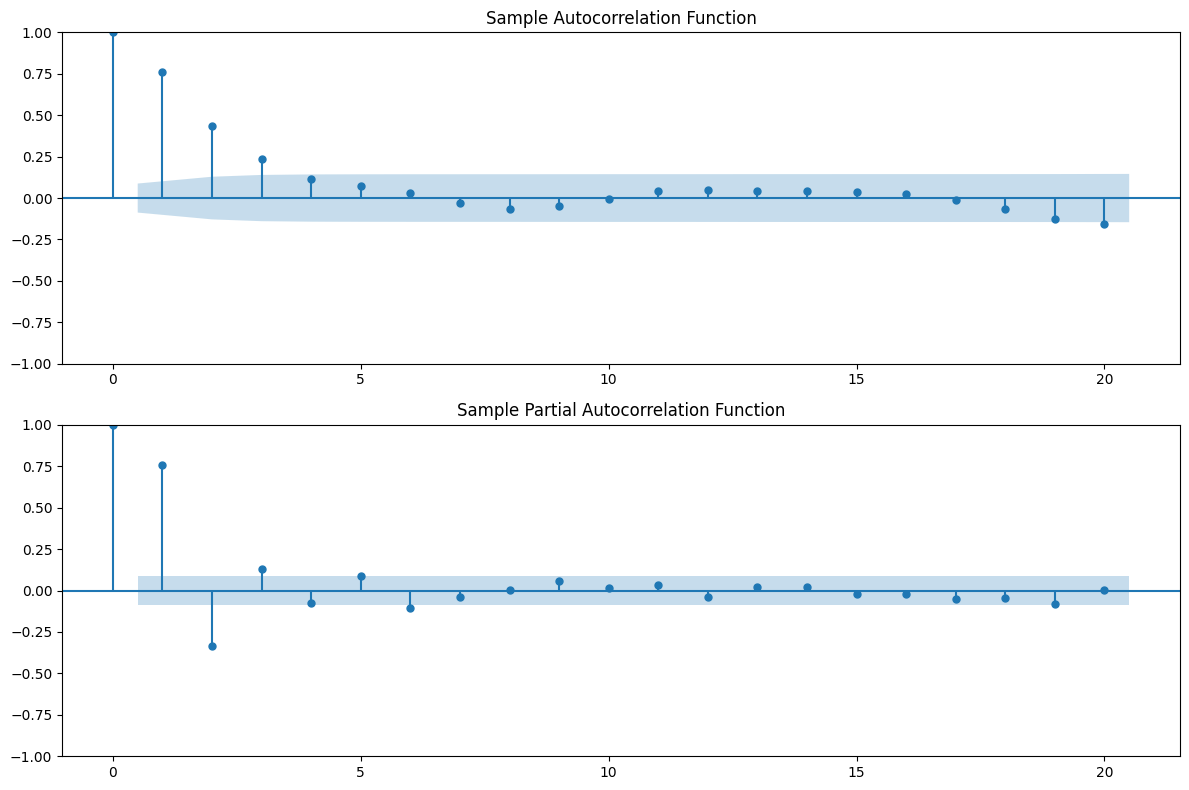

In [29]:

# Step 5: Estimate ARMA parameters using statsmodels
# --------------------------------------------------

# Fit an ARMA(1,1) model using statsmodels' ARIMA function (with order (p, d, q))
# Since the data is stationary, d=0
model = ARIMA(y, order=(1, 0, 1))
result_sm = model.fit()

# Extract parameters and their names
params = result_sm.params
param_names = result_sm.param_names

# Print parameters and their names
print("\nEstimated parameters using statsmodels:")
for name, value in zip(param_names, params):
    print(f"{name}: {value}")

# Access parameters by name
phi_index = param_names.index('ar.L1')
theta_index = param_names.index('ma.L1')

phi_sm = params[phi_index]
theta_sm = params[theta_index]

print(f"\nEstimated AR coefficient (phi): {phi_sm:.4f}")
print(f"Estimated MA coefficient (theta): {theta_sm:.4f}")

# Step 6: Compare estimated parameters to true parameters
# -------------------------------------------------------

print("\nTrue parameters:")
print(f"phi: {phi:.4f}")
print(f"theta: {theta:.4f}")

# Step 7: Conclusion
# ------------------

# The initial AR coefficients estimated using the Yule-Walker equations provide a good starting point.
# Using the Hannan-Rissanen algorithm, we estimated the MA coefficient.
# The refined estimates are close to the true parameters.
# The parameters estimated using statsmodels (maximum likelihood estimation) are also close.

# Note:
# - Estimating ARMA models manually is complex due to the dependence of current residuals on past errors.
# - The Hannan-Rissanen algorithm provides a practical way to estimate ARMA models using Yule-Walker equations.

# Plot the sample ACF and PACF for visual analysis
lags = 20

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# Plot ACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(y, lags=lags, ax=ax[0])
ax[0].set_title('Sample Autocorrelation Function')

# Plot PACF
plot_pacf(y, lags=lags, ax=ax[1], method='ywm')
ax[1].set_title('Sample Partial Autocorrelation Function')

plt.tight_layout()
plt.show()